In [4]:
import numpy as np
from functools import cached_property

In [35]:
class DenseLayer:
    def __init__(self,
                 n_in: int,
                 n_neu: int,
                 activation_function: str):
        self.n_neu = n_neu
        self.activ_func = self.get_activ_func(activation_function)
        self.d_activ_func = self.get_d_activ_func(activation_function)
        self.weights = 2*np.random.random((n_in, n_neu))-1

    def get_activ_func(self, activation_function: str):
        activ_func_dict = {'sigmoid': lambda x: 1 / (1 + np.exp(-x)),
                           'softplus': lambda x: np.log(np.exp(x) + 1)}
        return activ_func_dict.get(activation_function)
    
    def get_d_activ_func(self, activation_function: str):
        activ_func_dict = {'sigmoid': lambda x: np.exp(-x) / (1 + np.exp(-x))**2,
                           'softplus': lambda x: np.log(np.exp(x) + 1)} #wrong
        return activ_func_dict.get(activation_function)
    
    def forward_prop(self, input):
        print(self.weights)
        print(input)
        self.out = self.weights @ input
        return self.activ_func(self.out)
    
    def back_prop(self, output, dlda,  learning_rate: float):
        # a = self.forward_prop() - output
        self.delta = dlda * self.d_activ_func(output)
        self.result = self.delta * output.t #transposed
        self.weights -= learning_rate * self.result

    # def weigth_update(self,, output, dlda):
        


In [36]:
class NeuralNetwork:
    def __init__(self,
                 n_in: int,
                 n_out: int):
        self.n_in = n_in #number of input features
        self.n_out = n_out #number of output targets
        self.layers = [] #list of layers
    
    def add_layer(self,
                  n_neu: int,
                  activation_function: str):
        self.layers.append(DenseLayer(self.n_in, n_neu, activation_function))

    def fit(self, train_features: np.array, train_targets: np.array, epochs: int, learning_rate):
        self.loss = []
        for i in range(epochs):
            loss = []
            for j in range(len(train_features)):
                layer_out = train_features.copy()[j,]
                for layer in self.layers:
                    layer_out = layer.forward_prop(layer_out)

                loss.append(np.mean((train_targets[j]-layer_out)**2))

                dlda = layer_out - train_targets.copy()[j,]
                for layer in self.layers[::-1]:
                    layer.back_prop(layer.out, dlda, learning_rate)
                    dlda = layer.weights @ layer.delta
            self.loss.append(loss)

    def predict(self, test_features: np.array, test_targets: np.array):
        result = []
        self.errors = []
        for j in range(len(test_features)):
            layer_out = test_features.copy()[j,]
            for layer in self.layers:
                layer_out = layer.forward_prop(layer_out)
            result.append(layer_out)
            self.errors.append(np.mean((test_targets[j]-layer_out)**2))
        return result


In [28]:
from keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [29]:
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255
test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype('float32') / 255

In [30]:
from keras.utils import to_categorical
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [37]:
first_network = NeuralNetwork(n_in=28*28, n_out=10)

In [38]:
first_network.add_layer(3,'sigmoid')
first_network.add_layer(3,'sigmoid')

In [39]:
first_network.fit(train_images, train_labels, epochs=3, learning_rate=.01)

[[-0.27407848  0.09418744 -0.69299178]
 [ 0.61773894 -0.27026845 -0.44120727]
 [ 0.34252692 -0.88565365  0.99921725]
 ...
 [-0.97283974  0.71449895  0.22889616]
 [ 0.6129316  -0.99597921 -0.21380259]
 [ 0.51963222 -0.20040565 -0.47063194]]
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.     

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 784 is different from 3)

# New version

In [1]:
import assignment3 as neu
import numpy as np
from matplotlib import pyplot as plt
from keras.datasets import mnist
from keras.utils import to_categorical

In [2]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255
test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype('float32') / 255


In [3]:
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [4]:
first_network = neu.NeuralNetwork()
first_network.add_layer(28*28, 128,'relu')
# first_network.add_layer(128, 64,'relu')
# first_network.add_layer(64, 32,'sigmoid')
first_network.add_layer(128, 10,'softmax')

In [5]:
#lista liczb neuronów i żeby samo się utworzyło
#zbiór obserwacji podzielić na wsady (2**... czy po sto), po każdej liczymy gradient ale wagi updatujemy na koniec, rozmiar batcha żeby się dało podać (ostatni batch to to zostało jak zbiór się nie dZieli)
#funkcja aktywacji czy funkcja kosztu do wyboru
first_network.fit(train_images, train_labels, epochs=10, learning_rate=.01, validation=(test_images, test_labels))

0


KeyboardInterrupt: 

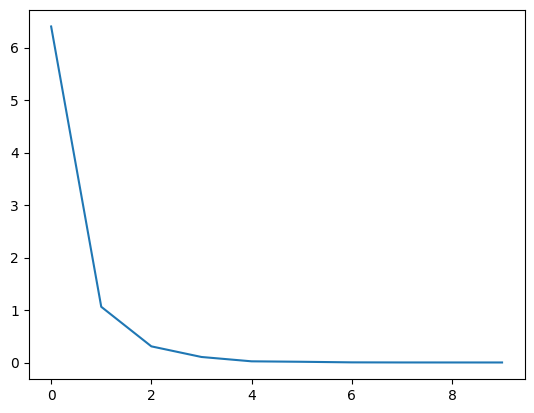

In [ ]:
plt.plot(first_network.loss)

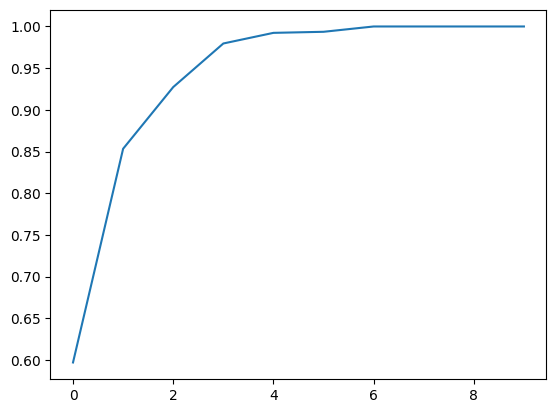

In [ ]:
plt.plot(first_network.acc)

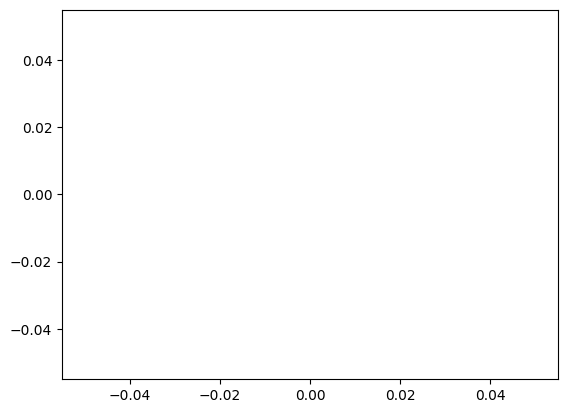

In [ ]:
plt.plot(first_network.val_acc)

In [8]:
predicted = first_network.predict(test_images, test_labels)

In [10]:
predicted

array([1.85774771e-20, 9.99963166e-01, 7.52870385e-17, 6.46210256e-09,
       2.05823186e-13, 4.14931895e-09, 1.35077057e-08, 3.67895057e-05,
       2.07630881e-08, 9.89854549e-14])

In [11]:
predicted.round()

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])

In [12]:
test_labels[-1,:]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])

In [6]:
np.arange(7)

array([0, 1, 2, 3, 4, 5, 6])

In [9]:
first_network.errors

0.7385204081632653

In [ ]:
test_labels.shape

(10000, 10)

In [14]:
test_labels.shape

(10000, 10)